In [1]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'ai_miniproject.ipynb'
import wandb
wandb.login()

wandb: Currently logged in as: guswns0528 (guswns0528-seoul-national-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
sweep_config = {
    'method': 'random'
}

metric = {
    'name': 'val_loss',
    'goal': 'minimize'   
}

sweep_config['metric'] = metric

parameters_dict = {
    'epochs': {
        'values': [20, 40]
    },
    'in_train': {
        'value': True
    },
}

import math
parameters_dict['lr'] = {
    'distribution': 'log_uniform',
    'min': math.log(1e-4),
    'max': math.log(0.1),
}
parameters_dict['lr'] = { 'value': 0.03 }

parameters_dict['optimizer'] = {
    'values': ['adam', 'sgd']
}
parameters_dict['optimizer'] = { 'value' : 'sgd' }

parameters_dict['batch_size'] = {
    'distribution': 'q_log_uniform_values',
    'q': 32,
    'min': 128,
    'max': 1024,
}
parameters_dict['batch_size'] = {
    'value': 256
}

parameters_dict['momentum'] = {
    'distribution': 'uniform',
    'min': 0.0,
    'max': 1.0,
}
parameters_dict['momentum'] = { 'value': 0.9 }

parameters_dict['weight_decay'] = {
    'values': [1e-5, 1e-4, 1e-3]
}
parameters_dict['weight_decay'] = { 'value': 1e-5 }
    
sweep_config['parameters'] = parameters_dict
sweep_config['early_terminate'] = {
    'type': 'hyperband',
    's': 2,
    'eta': 3,
    'max_iter': 18,
}

In [38]:
sweep_id = wandb.sweep(sweep_config, project="ai-miniproject")

wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. lr uses log_uniform, where min/max specify base-e exponents. Use log_uniform_values to specify limit values.


Create sweep with ID: ymg74elm
Sweep URL: https://wandb.ai/guswns0528-seoul-national-university/ai-miniproject/sweeps/ymg74elm


In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from resnet import resnet110
from torch_lr_finder import LRFinder

from tqdm.auto import tqdm
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

import numpy as np

from torcheval.metrics.functional import multiclass_confusion_matrix
import seaborn as sn
import pandas as pd

torch.backends.cudnn.benchmark = True

device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_type)

In [98]:
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        stride = 1 if in_channels == out_channels else 2
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = lambda x: x
        if stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, padding=0, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.block(x)
        out = F.relu(self.downsample(x) + out)
        return out
        
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        block = Residual
        self.initial = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )
        self.residual_layers = nn.Sequential(
            *([block(16, 16) for _ in range(4)] + 
            [block(16, 32)] + [block(32, 32) for _ in range(4 - 1)] +
            [block(32, 64)] + [block(64, 64) for _ in range(4 - 1)])
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.initial(x)
        x = self.residual_layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [100]:
from torchvision.transforms import v2

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_and_val = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transform
    ])
)

total = len(train_and_val)
trainset = torch.utils.data.Subset(train_and_val, range(int(total * 0.8)))
validationset = torch.utils.data.Subset(train_and_val, range(int(total * 0.8), total))

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [6]:
def baseline(batch_size):
    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        prefetch_factor=8,
    )
    valloader = torch.utils.data.DataLoader(
        validationset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        prefetch_factor=8,
    )
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8
    )
    return trainloader, valloader, testloader

In [63]:
class RandomLabelDataset(torch.utils.data.Dataset):
    def __init__(self, origin):
        super().__init__()
        self.origin = origin
        self.label_indicies = [i for i in range(len(origin))]
        np.random.shuffle(self.label_indicies)

    def __getitem__(self, idx):
        return self.origin[idx][0], self.origin[self.label_indicies[idx]][1]

    def __getitems__(self, indicies):
        return [self[idx] for idx in indicies]

    def __len__(self):
        return len(self.origin)

random_label_trainset = RandomLabelDataset(trainset)
def random_label(batch_size, reset=False):
    trainloader = torch.utils.data.DataLoader(
        random_label_trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        prefetch_factor=8,
    )
    valloader = torch.utils.data.DataLoader(
        validationset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        prefetch_factor=8,
    )
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8
    )
    return trainloader, valloader, testloader

In [66]:
class NoiseLabelDataset(torch.utils.data.Dataset):
    def __init__(self, origin, error_rate=0.2):
        super().__init__()
        self.origin = origin
        self.error_rate = error_rate
        self.labels = [
            np.random.randint(0, 10) if np.random.uniform(0, 1, 1) <= error_rate else self.origin[i][1]
            for i in range(len(origin))
        ]

    def __getitem__(self, idx):
        v, _ = self.origin[idx]
        label = self.labels[idx]
        return v, label

    def __getitems__(self, indicies):
        return [self[idx] for idx in indicies]
        
    def __len__(self):
        return len(self.labels)

noise_label_trainset = NoiseLabelDataset(trainset)
def noise_label(batch_size, reset=False):
    trainloader = torch.utils.data.DataLoader(
        noise_label_trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        prefetch_factor=8,
    )
    valloader = torch.utils.data.DataLoader(
        validationset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        prefetch_factor=8,
    )
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8
    )
    return trainloader, valloader, testloader

In [103]:
pertubation_transform = transforms.Compose([
    transforms.v2.AutoAugment(
        policy=torchvision.transforms.autoaugment.AutoAugmentPolicy.CIFAR10,
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

pertubation_train_and_val = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([
        pertubation_transform
    ])
)
pertubation_trainset = torch.utils.data.Subset(pertubation_train_and_val, range(int(total * 0.8)))

def pertubation(batch_size):
    trainloader = torch.utils.data.DataLoader(
        pertubation_trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        prefetch_factor=8,
    )
    valloader = torch.utils.data.DataLoader(
        validationset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        prefetch_factor=8,
    )
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8
    )
    return trainloader, valloader, testloader

In [99]:
def train_epoch(model, loader, optimizer, scaler, train=True, result=False):
    if train:
        model.train()
    else:
        model.eval()
    criterion = nn.CrossEntropyLoss().to(device)

    total = torch.zeros(1, device=device)
    correct = torch.zeros(1, device=device)
    total_loss = torch.zeros(1, device=device)

    preds = []
    truthes = []
    
    def train_batch(i, data):
        nonlocal total, correct, total_loss, criterion
        inputs, labels = [x.to(device) for x in data]
        inputs = inputs.to(memory_format=torch.channels_last)
        optimizer.zero_grad(set_to_none=True)
        with torch.autocast(device_type=device_type, dtype=torch.float16, enabled=True):
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum()
            loss = criterion(outputs, labels)
        total += labels.size(0)
        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        total_loss += loss
        if result:
            preds.extend(predicted.data.cpu().numpy())
            truthes.extend(labels.data.cpu().numpy())

    for i, data in enumerate(loader):
        if train:
            train_batch(i, data)
        else:
            with torch.no_grad():
                train_batch(i, data)

    avg_loss = (total_loss / total).item()
    accuracy = (correct / total).item()

    if result:
        return accuracy, avg_loss, preds, truthes
    else:
        return accuracy, avg_loss
        
def train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        in_train = config.in_train
        epochs = config.epochs
        scaler = torch.amp.GradScaler("cuda", enabled=True)
        dataset = config.get('dataset', 'baseline')
        if dataset == 'baseline':
            dataset_function = baseline
        elif dataset == 'random_label':
            dataset_function = random_label
        elif dataset == 'noise_label':
            dataset_function = noise_label
        elif dataset == 'pertubation':
            dataset_function = pertubation
        trainloader, valloader, testloader = dataset_function(config.batch_size)
        optimizer_type = config.optimizer
        lr = config.lr
        model = Net().to(device, memory_format=torch.channels_last)
        wandb.watch(model)
        if optimizer_type == 'adam':
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        elif optimizer_type == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=config.momentum, weight_decay=config.weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=10, threshold=1e-4, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-8)
        #scheduler = None
        if in_train:
            for epoch in range(epochs):
                accuracy, avg_loss = train_epoch(model, trainloader, optimizer, scaler)
                val_accuracy, val_avg_loss = train_epoch(model, valloader, optimizer, scaler, train=False)
                wandb.log({
                    'val_loss': val_avg_loss,
                    'loss': avg_loss,
                    'acc': accuracy,
                    'val_acc': val_accuracy,
                    "epoch": epoch,
                })
            if scheduler:
                scheduler.step(val_avg_loss)

        test_accuracy, test_avg_loss, preds, truthes = train_epoch(model, testloader, optimizer, scaler, train=False, result=True)
        wandb.log({
            'test loss': test_avg_loss,
            'test acc': test_accuracy,
        })
    return model, preds, truthes

In [ ]:
wandb.agent(sweep_id, train, count=500)

In [106]:
config = {
    'batch_size': 256,
    'epochs': 100,
    'in_train': True,
    'lr': 0.03,
    'momentum': 0.9,
    'optimizer': 'sgd',
    'weight_decay': 1e-5,
    'entity': 'guswns0528-seoul-national-university',
    'project': 'ai-miniproject',
    'dataset': 'baseline'
}
model, preds, truthes = train(config)

acc,▁▂▄▄▅▆▆▇▇█▇███████████████████▇█████████
epoch,▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
loss,█▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test acc,▁
test loss,▁
val_acc,▁▃▆▄▆▇▆▆▆▆▇▇▇▇▇▇▇████████████▇██████████
val_loss,█▁▁▄▃▄▄▃▄▃▄▃▃▃▃▃▃▃▃▃▃▄▃▄▃▃▇█▄▃▃▃▃▃▄▄▃▃▃▃
acc,1
epoch,99
loss,0.0
test acc,0.8172


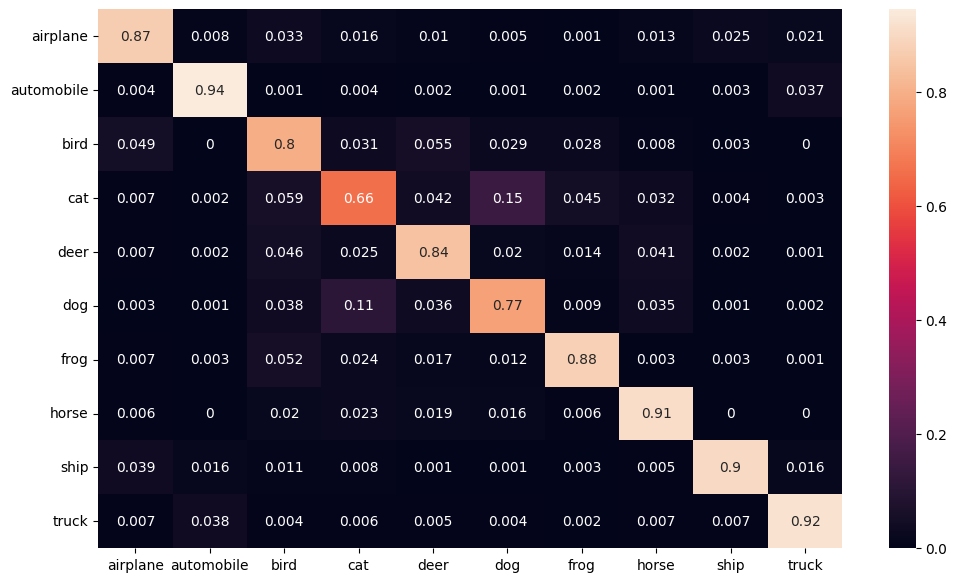

In [105]:
classes = train_and_val.classes
cf_matrix = multiclass_confusion_matrix(torch.tensor(preds), torch.tensor(truthes), len(classes)).data.numpy()
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('confusion_matrix_pertubation.png')

In [96]:
noise_data = model, preds, truthes

In [7]:
def test(model, loader, n=1):
    model.eval()
    criterion = nn.CrossEntropyLoss().to(device)
    total = 0
    correct = 0
    loss = 0.0
    with torch.no_grad():
        for data in loader:
            images, labels = [x.to(device) for x in data]
            outputs = model(images.to(memory_format=torch.channels_last))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss += criterion(outputs, labels).item()
    #print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    return correct / total, loss / total

In [8]:
def plot(accuracy, test_accuracy, losses, test_losses, lr):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Results at lr: {lr}")
    #ax1.set_ylim(0, 1)
    ax1.plot(accuracy, label="acc train")
    ax1.plot(test_accuracy, label="acc test")
    ax1.legend()
    ax1.set(xlabel="epoch", ylabel="acc")

    ax2.set_yscale('log')
    ax2.plot(losses, label="train loss")
    ax2.plot(test_losses, label="test loss")
    ax2.legend()
    ax2.set(xlabel="epoch", ylabel="loss")